In [10]:
import numpy as np
np.random.seed(123)  # for reproducibility
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.datasets import mnist
import matplotlib.pyplot as plt

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from sklearn.utils import shuffle

from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import pickle
import cv2
import glob
import time
from collections import deque

%matplotlib inline

In [6]:
def load_data():
 # Loading + training,validation test split
    cars0 = glob.glob('Car_dataset/vehicles/GTI_Far/*.png')
    cars1 = glob.glob('Car_dataset/vehicles/GTI_MiddleClose/*.png')
    cars2 = glob.glob('Car_dataset/vehicles/GTI_Left/*.png')
    cars3 = glob.glob('Car_dataset/vehicles/GTI_Right/*.png')
    cars4 = glob.glob('Car_dataset/vehicles/KITTI_extracted/*.png')
    #cars4 += glob.glob('./vehicles/augmentation/*.png')
    notcars1 = glob.glob('Car_dataset/non-vehicles/Extras/*.png')
    notcars1 += glob.glob('Car_dataset/non-vehicles/GTI/*.png')

    # split 70% training 20% validation 10% test set
    frac1 = 0.7
    l0,l1,l2,l3,l4,l5=len(cars0),len(cars1),len(cars2),len(cars3),len(cars4),len(notcars1)
    L1 = (frac1*np.array([l0,l1,l2,l3,l4,l5])).astype('int')
    frac2 = 0.9
    l0,l1,l2,l3,l4,l5=len(cars0),len(cars1),len(cars2),len(cars3),len(cars4),len(notcars1)
    L2 = (frac2*np.array([l0,l1,l2,l3,l4,l5])).astype('int')

    cars_train = cars0[:L1[0]] + cars1[:L1[1]] + cars2[:L1[2]] + cars3[:L1[3]] + cars4[:L1[4]]
    notcars_train = notcars1[:L1[5]]

    cars_val = cars0[L1[0]:L2[0]] + cars1[L1[1]:L2[1]] + cars2[L1[2]:L2[2]] + cars3[L1[3]:L2[3]] + cars4[L1[4]:L2[4]]
    notcars_val = notcars1[L1[5]:L2[5]]

    cars_test = cars0[L2[0]:] + cars1[L2[1]:] + cars2[L2[2]:] + cars3[L2[3]:] + cars4[L2[4]:]
    notcars_test = notcars1[L2[5]:]
    
    return cars_train, notcars_train, cars_val, notcars_val, cars_test, notcars_test

In [7]:
cars_train, notcars_train, cars_val, notcars_val, cars_test, notcars_test = load_data()

cars_train_4d = np.zeros(shape=(64,64,3))
for i in range (len(cars_train)):
    cars_train[i] = mpimg.imread(cars_train[i])
cars_train_4d = np.stack(cars_train,axis=0)

cars_test_4d = np.zeros(shape=(64,64,3))
for i in range (len(cars_test)):
    cars_test[i] = mpimg.imread(cars_test[i])
cars_test_4d = np.stack(cars_test,axis=0)

cars_val_4d = np.zeros(shape=(64,64,3))
for i in range (len(cars_val)):
    cars_val[i] = mpimg.imread(cars_val[i])
cars_val_4d = np.stack(cars_val,axis=0)

notcars_val_4d = np.zeros(shape=(64,64,3))
for i in range (len(notcars_val)):
    notcars_val[i] = mpimg.imread(notcars_val[i])
notcars_val_4d = np.stack(notcars_val,axis=0)

notcars_train_4d = np.zeros(shape=(64,64,3))
for i in range (len(notcars_train)):
    notcars_train[i] = mpimg.imread(notcars_train[i])
notcars_train_4d = np.stack(notcars_train,axis=0)

notcars_test_4d = np.zeros(shape=(64,64,3))
for i in range (len(notcars_test)):
    notcars_test[i] = mpimg.imread(notcars_test[i])
notcars_test_4d = np.stack(notcars_test,axis=0)

print("shapes of arrays:", cars_train_4d.shape, notcars_train_4d.shape, cars_val_4d.shape, notcars_val_4d.shape, cars_test_4d.shape, notcars_test_4d.shape)

shapes of arrays: (6152, 64, 64, 3) (6277, 64, 64, 3) (1759, 64, 64, 3) (1794, 64, 64, 3) (881, 64, 64, 3) (897, 64, 64, 3)


In [8]:
#Create an array stack of feature vectors
X_train = np.vstack((cars_train_4d, notcars_train_4d))
X_val = np.vstack((cars_val_4d, notcars_val_4d))
X_test = np.vstack((cars_test_4d, notcars_test_4d))
y_train = np.hstack((np.ones(len(cars_train_4d)),np.zeros(len(notcars_train_4d))))
y_val = np.hstack((np.ones(len(cars_val_4d)),np.zeros(len(notcars_val_4d))))
y_test = np.hstack((np.ones(len(cars_test_4d)),np.zeros(len(notcars_test_4d))))

print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(12429, 64, 64, 3) (3553, 64, 64, 3) (1778, 64, 64, 3) (12429,) (3553,) (1778,)


In [15]:
# Initializing the CNN
classifier = Sequential()

# Step 1 - Convolution
classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))

# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
classifier.add(Flatten())

# Step 4 - Full connection
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dense(units = 1, activation = 'sigmoid'))

# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

#gather history info
history = classifier.fit(X_train, y_train, validation_data=(X_val,y_val),batch_size=32, epochs=12, verbose=1)

# list all data in history
print(history.history.keys())

Train on 12429 samples, validate on 3553 samples
Epoch 1/12
12429/12429 [==============================] - 50s 4ms/step - loss: 0.1557 - acc: 0.9389 - val_loss: 0.1033 - val_acc: 0.9716
Epoch 2/12
12429/12429 [==============================] - 52s 4ms/step - loss: 0.0623 - acc: 0.9792 - val_loss: 0.0859 - val_acc: 0.9764
Epoch 3/12
12429/12429 [==============================] - 49s 4ms/step - loss: 0.0422 - acc: 0.9863 - val_loss: 0.0515 - val_acc: 0.9840
Epoch 4/12
12429/12429 [==============================] - 49s 4ms/step - loss: 0.0279 - acc: 0.9903 - val_loss: 0.0972 - val_acc: 0.9685
Epoch 5/12
12429/12429 [==============================] - 50s 4ms/step - loss: 0.0179 - acc: 0.9942 - val_loss: 0.0340 - val_acc: 0.9885
Epoch 6/12
12429/12429 [==============================] - 50s 4ms/step - loss: 0.0186 - acc: 0.9937 - val_loss: 0.0684 - val_acc: 0.9741
Epoch 7/12
12429/12429 [==============================] - 51s 4ms/step - loss: 0.0228 - acc: 0.9920 - val_loss: 0.0442 - val_acc:

12
12


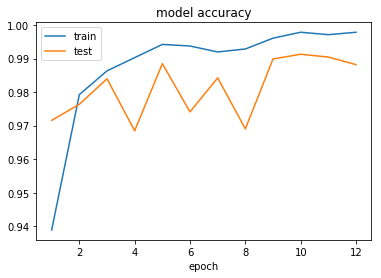

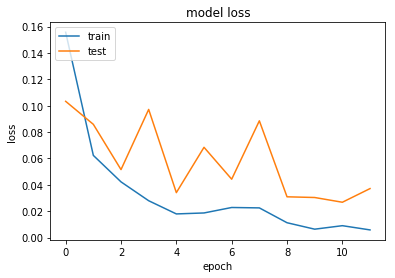

In [17]:
%matplotlib inline
# summarize history for accuracy
acc = history.history['acc']
print(len(acc))
val_acc = history.history['val_acc']
epochs = range(1, len(acc)+1)
print(len(acc))

plt.plot(epochs, acc, label='training acc')
plt.plot(epochs, val_acc, label='validation acc')
plt.title('model accuracy')
#plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

The test image is a: car


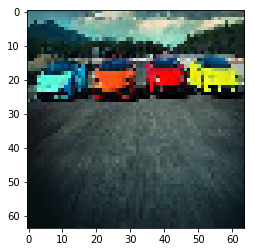

In [26]:
import numpy as np
from keras.preprocessing import image
test_image = image.load_img('Car_dataset_CNN/visualtestex/lambos.jpeg', target_size = (64,64))
plt.imshow(test_image)
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = classifier.predict(test_image)
if result[0][0] == 1:
    prediction = 'car'
else:
    prediction = 'non-car'

print("The test image is a:",prediction)